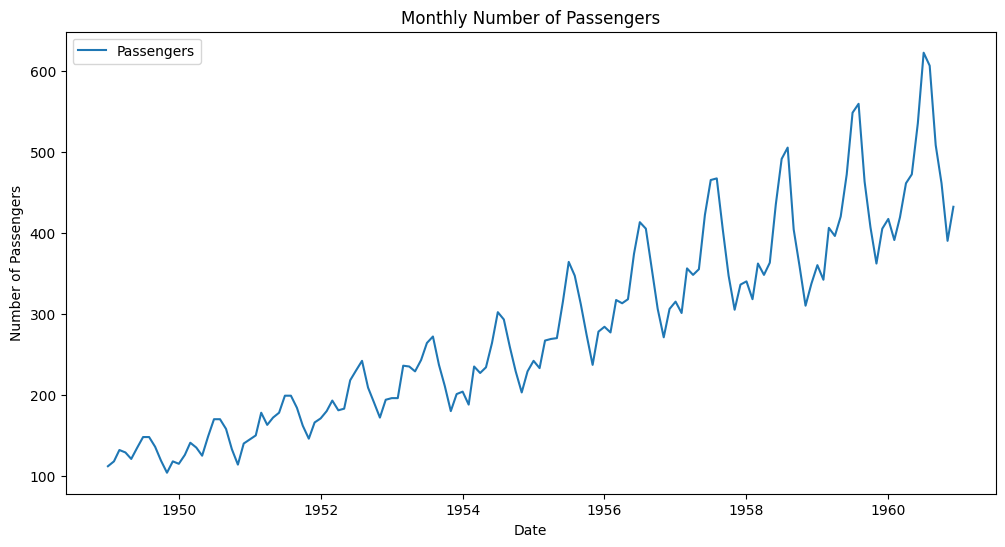

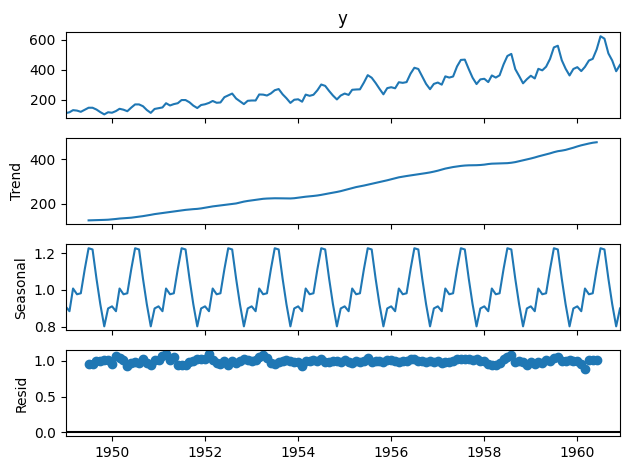

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Best SARIMA configuration: ((2, 0, 0), (2, 0, 0, 12))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 182.04711106090056
Mean Absolute Error: 11.074652845384096


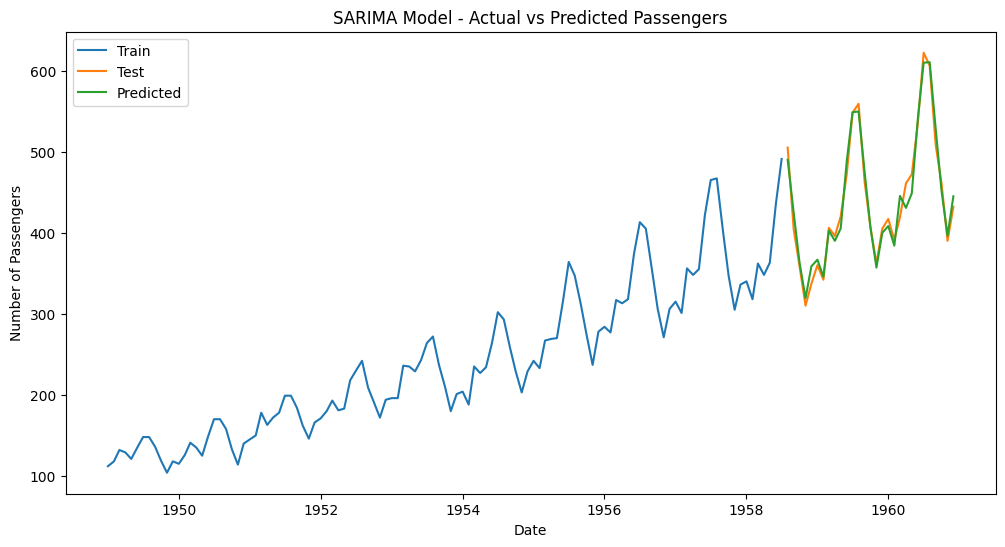

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = sns.load_dataset('flights')
df['year'] = df['year'].astype(str)
df['month'] = df['month'].map({
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}).astype(str)
df['date'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-01')
df.set_index('date', inplace=True)
df.drop(['year', 'month'], axis=1, inplace=True)
df.rename(columns={'passengers': 'y'}, inplace=True)

# EDA: Line plot and seasonal decomposition
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Passengers')
plt.title('Monthly Number of Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

result = seasonal_decompose(df['y'], model='multiplicative')
result.plot()
plt.show()

# Feature Engineering
df['month'] = df.index.month
df['year'] = df.index.year

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Modeling and hyperparameter tuning
def sarima_grid_search(train, test, param_grid):
    tscv = TimeSeriesSplit(n_splits=3)
    best_score, best_cfg = float("inf"), None
    for p in param_grid['p']:
        for d in param_grid['d']:
            for q in param_grid['q']:
                for P in param_grid['P']:
                    for D in param_grid['D']:
                        for Q in param_grid['Q']:
                            for s in param_grid['s']:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, s)
                                try:
                                    model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order,
                                                    enforce_stationarity=False, enforce_invertibility=False)
                                    results = model.fit(disp=False)
                                    y_pred = results.predict(start=test.index[0], end=test.index[-1])
                                    mse = mean_squared_error(test['y'], y_pred)
                                    if mse < best_score:
                                        best_score, best_cfg = mse, (order, seasonal_order)
                                except:
                                    continue
    return best_cfg

param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    's': [12]
}

best_cfg = sarima_grid_search(train, test, param_grid)
print(f'Best SARIMA configuration: {best_cfg}')

# Train the best model
model = SARIMAX(train['y'], order=best_cfg[0], seasonal_order=best_cfg[1],
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Predict and evaluate
y_pred = results.predict(start=test.index[0], end=test.index[-1])
print(f"Mean Squared Error: {mean_squared_error(test['y'], y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(test['y'], y_pred)}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test')
plt.plot(test.index, y_pred, label='Predicted')
plt.title('SARIMA Model - Actual vs Predicted Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
